# Predicting music genre using Convolutional Neural Networks

## A short description of the dataset

The dataset we will be using in this notebook comes from a dump of the Free Music Archive (FMA), available [in this Github repository](https://github.com/mdeff/fma). The complete description of this project may be found [in this paper](https://arxiv.org/abs/1612.01840).

To summarise, whole dataset is comprised of 106,574 of Creative Commons-licenced tracks from 16,341 artists and 14,854 albums, arranged in a hierarchical structure of 161 genres. However, in this notebook, we will be focusing on a **smaller subset** of this initial dataset: the dataset we will be focusing on will be comprised of **$8,000$ 30 second clips**. Those clipe belong to 8 top genres, balanced with $1,000$ clips per genre.

Our goal in this notebook will be to classify the genre of an unknown track among the 8 genres that are present in our dataset.

## Downloading the dataset

First of all, let's download the data that we will be using. Since the files are quite heavy (>7 GB in total), we download in the Jupyter Notebook instead of having them directly. We then unzip the content of the files.

The whole dataset is entirely in the cloud, so it removes constraints about data space or anything.

**Note: Please note that the whole process may be a bit long (~15 minutes).**


In [4]:
!curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!curl -O https://os.unil.cloud.switch.ch/fma/fma_small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341M  100  341M    0     0  23.5M      0  0:00:14  0:00:14 --:--:-- 25.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7323M  100 7323M    0     0  25.4M      0  0:04:47  0:04:47 --:--:-- 25.7M


In [0]:
!unzip fma_metadata.zip
!unzip fma_small.zip

First of all, let's download the data that we will be using. Since the files are quite heavy (>7 GB in total), we download in the Jupyter Notebook instead of having them directly.

## Data exploration

In [0]:
import pandas as pd
import numpy as np
import os

The full information about the tracks, including the genre, can be found in the file `tracks.csv`. As for the genre, the according code can be retrieved in the file `genres.csv`.

In [116]:
genres = pd.read_csv('/content/fma_metadata/genres.csv')
tracks = pd.read_csv('/content/fma_metadata/tracks.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [117]:
# The first two lines are a bit buggy, so we remove them 
tracks.columns = ["track_id"] + list(tracks.iloc[0])[1:]
tracks = tracks.drop(tracks.index[[0,1]])
tracks = tracks.reset_index()
tracks[:5]

,index,track_id,comments,date_created,date_released,engineer,favorites,id,information,listens,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,5,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,6,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level
5,7,26,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,...,NaN,1060,en,Attribution-NonCommercial-NoDerivatives (aka M...,193,NaN,4,NaN,[],Where is your Love?
6,8,30,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,...,NaN,718,en,Attribution-NonCommercial-NoDerivatives (aka M...,612,NaN,5,NaN,[],Too Happy
7,9,46,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,...,NaN,252,en,Attribution-NonCommercial-NoDerivatives (aka M...,171,NaN,8,NaN,[],Yosemite
8,10,48,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,...,NaN,247,en,Attribution-NonCommercial-NoDerivatives (aka M...,173,NaN,9,NaN,[],Light of Light
9,11,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,...,NaN,1126,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,NaN,5,NaN,[],Street Music


If we take a look at the `tracks.csv` file, we notice that there are many columns that we do not need. In fact, we only need two pieces of information: the **track_id** (in order to know to which song we are referring) and the **corresponding genre**.

In [214]:
# We reduce the dataset in order to only keep the track ID and the genre
reduced_tracks = pd.DataFrame({'track_id': tracks.track_id, 'genres': tracks.genres})
reduced_tracks.track_id = reduced_tracks.track_id.astype(int)
reduced_tracks.set_index('track_id', inplace = True) 
reduced_tracks[:10]

,genres
track_id,
2,[21]
3,[21]
5,[21]
10,[10]
20,"[76, 103]"
26,"[76, 103]"
30,"[76, 103]"
46,"[76, 103]"
48,"[76, 103]"


In [168]:
len(reduced_tracks)

106574

There is another problem: we are working on a **small subset** of an original dataset, while the metadata refers to the **entirety of the original dataset** (which explains why the previous dataset has over $100,000$ rows). For this reason, we will need to remove all the lines that refer to tracks that are not present in our sample.

### Finding the track names

In [0]:
# We iterate over all files in the `fma_small` folder, in order to get their names
file_list = []

for root, dirs, files in os.walk("/content/fma_small"):  
    file_list += [file_name for file_name in files]

file_list = file_list[2:]

In [0]:
# We then remove the '.mp3' extension and take the remaining name
track_list = []

for file_name in file_list:
  track_id = int(file_name.split('.')[0])
  track_list += [track_id]

 As a sanity check, we can see that the number of track names we have is indeed equal to the total number of tracks:

In [171]:
len(track_list)

8000

We can then use those track names to reduce the length of our dataset to the expected $8,000$ rows.

In [215]:
reduced_tracks = reduced_tracks.reindex(track_list).sort_index()
reduced_tracks[:10]

,genres
track_id,
2,[21]
5,[21]
10,[10]
140,[17]
141,[17]
148,[1]
182,[27]
190,[17]
193,[17]


### Finding the right genre
The people who have created this dataset have made it so that each song belongs to **one genre** out of **eight possible genres**. However, in this dataset, we can see that some songs have several genres attributed to them – in that case, it means that all its genres are "subsets" of a single "parent" genre.

For most rows, the "parent" genre is the first genre listed (or the only genre mentionned). However, in certain cases, we find that there are **only subgenres** that are present, and that the "parent" genre is missing.

In the end, the goal of this section is to only keep the "parent" genre, which is supposed to be unique, for every track we have in our dataset.

In [0]:
genres.top_level = genres.top_level.astype(int)
genres.genre_id = genres.genre_id.astype(int)
genres.set_index('genre_id', inplace = True)

In [0]:
def parent_genre(genre_list):
  
  """
  This is the function we apply on the `genres` column.
  We replace every genre by its parent genre (if it exists, otherwise we change nothing).
  
  Afterwards, for a given row, if all parent genres are the same, then we remove
  the list and keep the first element only.
  """
  
  genre_list = genre_list[1:-1].split(',')
  genre_list = [int(genres.loc[int(x)].top_level) if int(x) in genres.index else int(x) for x in genre_list]
  
  if len(set(genre_list)) == 1:
    return genre_list[0]
  
  else:
    return genre_list



reduced_tracks.genres = reduced_tracks.genres.apply(parent_genre, 1)

In [219]:
reduced_tracks[:10]

,genres
track_id,
2,21
5,21
10,10
140,17
141,17
148,38
182,12
190,17
193,17


Now, we just need to replace the genre code with the proper genre name.

In [221]:
reduced_tracks.genres = reduced_tracks.genres.apply(lambda x: genres.loc[x].title)
reduced_tracks[:10]

,genres
track_id,
2,Hip-Hop
5,Hip-Hop
10,Pop
140,Folk
141,Folk
148,Experimental
182,Rock
190,Folk
193,Folk


We can now save this reduced .csv file.

In [0]:
reduced_tracks.to_csv('/content/small_tracks.csv')

## A bit more exploration (EXPERIMENTAL)

In [225]:
features = pd.read_csv('/content/fma_metadata/features.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,2

In [272]:
reduced_tracks.genres.unique()

array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

## Track transformation

From what we have seen, a very common approach to process sound files for Genre Recognition, either with CNN or other techniques, is to turn them into a mel spectrogram. This is what we do here, thanks to Librosa.

A few interesting sources **(maybe do not include this as a final presentation)**:
- http://deepsound.io/music_genre_recognition.html
- https://arxiv.org/pdf/1802.09697.pdf
- http://cs231n.stanford.edu/reports/2017/pdfs/22.pdf
- https://medium.com/@diegoagher/learning-music-genres-5ab1cabadfed **<- THEY HAVE WORKED ON OUR DATASET**
- https://arxiv.org/pdf/1709.04396.pdf

<br/>


Note: After installing Librosa, we install ffmpeg, because otherwise Librosa does not recognise .mp3 files.

<br/>

Other note: http://lbms03.cityu.edu.hk/theses/c_ftt/mphil-cs-b39478026f.pdf is another interesting paper.

In [230]:
!pip install librosa
!apt-get install ffmpeg

    100% |████████████████████████████████| 1.6MB 4.7MB/s 
    100% |████████████████████████████████| 327kB 9.2MB/s 
    100% |████████████████████████████████| 3.2MB 6.9MB/s 
    100% |████████████████████████████████| 16.1MB 995kB/s 
  Running setup.py bdist_wheel for librosa ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy


In [0]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [0]:
def mel_spec(file_name, display = True):
  
  song, sampling_rate = librosa.load('/content/fma_small/' + file_name)
  song_mel = librosa.feature.melspectrogram(song, sr = sampling_rate)
  
  if display == True:
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(song_mel,
                                          ref=np.max),
                          y_axis='mel', fmax=8000,
                          x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    
  return song_mel

array([[3.57158460e-02, 3.02197298e+00, 4.93031916e+00, ...,
        1.02696461e+01, 5.64958907e+00, 5.77691171e+00],
       [5.26786637e-01, 5.44097495e+00, 8.34403702e+00, ...,
        3.27244297e+01, 1.90993941e+01, 5.80582973e+00],
       [5.93512155e-01, 3.77734696e+00, 3.31257455e+00, ...,
        4.35422178e+01, 5.81348541e+01, 9.76912830e+01],
       ...,
       [4.44102442e-06, 3.02758096e-05, 8.55713310e-05, ...,
        1.15942836e-03, 2.19466198e-03, 3.65053675e-03],
       [1.06709055e-06, 5.01456187e-06, 1.15898287e-05, ...,
        8.76166024e-04, 1.26440414e-03, 2.62120398e-03],
       [4.34140102e-08, 5.16702524e-07, 1.59217207e-06, ...,
        1.80192876e-05, 3.73299517e-04, 2.01056028e-03]])

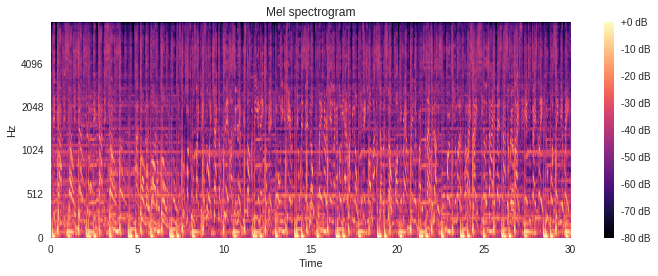

In [264]:
mel_spec('000/000005.mp3')

array([[2.13462138e-02, 7.35474429e-02, 8.46496081e-02, ...,
        2.82839678e-01, 5.23347465e-01, 1.79973219e+00],
       [5.86571014e-02, 1.29099654e-01, 8.59416139e-02, ...,
        8.51080129e+00, 8.67679945e+00, 5.35605151e+00],
       [1.12553187e-01, 2.92885727e-01, 5.97096331e-01, ...,
        2.66316725e+01, 3.58271888e+01, 1.72766716e+01],
       ...,
       [1.88505050e-06, 1.03486429e-05, 1.28674545e-05, ...,
        4.14398510e-05, 4.10883718e-05, 4.32295650e-04],
       [2.26515144e-07, 2.58055598e-06, 4.09771119e-06, ...,
        1.26828056e-05, 1.47868964e-05, 3.67112587e-04],
       [2.13079064e-08, 1.89564273e-07, 3.70663908e-07, ...,
        8.88262684e-07, 8.40271474e-07, 2.25587828e-04]])

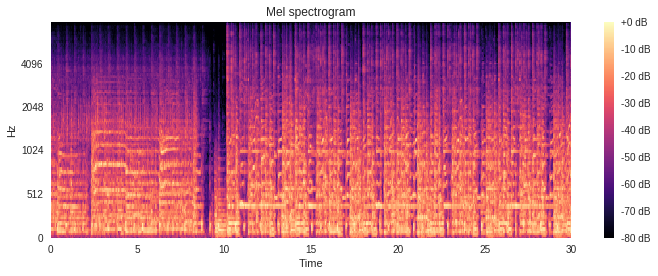

In [269]:
mel_spec('000/000255.mp3')

array([[1.66139203e+00, 2.91876695e+00, 1.99049625e+00, ...,
        1.23043344e-01, 8.02252690e-01, 1.46043589e+00],
       [1.47544708e+00, 2.89115691e+00, 2.64282714e+00, ...,
        1.13542580e+01, 1.57242097e+01, 3.24317822e+01],
       [1.80672867e+00, 3.91728256e+00, 6.65978966e+00, ...,
        1.60299473e+02, 1.07822607e+02, 1.02646013e+02],
       ...,
       [2.51391871e-05, 7.74222354e-05, 1.15768277e-04, ...,
        6.31023863e-04, 7.57313156e-04, 6.28439965e-04],
       [8.01266288e-06, 1.70406009e-05, 1.98543331e-05, ...,
        2.07523664e-04, 2.33577894e-04, 1.98682164e-04],
       [1.32555962e-06, 2.00051966e-06, 1.63818369e-06, ...,
        1.42191457e-05, 1.60719698e-05, 9.91664107e-05]])

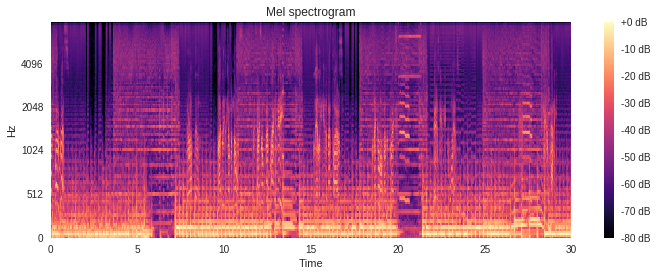

In [271]:
mel_spec('000/000368.mp3')